### Analysis for "Rapid seaward expansion of seaport footprints worldwide" (Sengupta & Lazarus, 2023: https://doi.org/10.31223/X5SD3T)
#### Revised: October 2023
#### This code uses (1) data for seaward seaport expansion between 1990–2020 (calculated separately, with Google Earth Engine: https://github.com/dhritirajsen/Seaport_reclamation), and (2) reported trade volume compiled from Lloyd's List reports ranking the top 100 container ports in the world, to generate time series and other summary analysis.

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import math

# Import curve-fitting package from scipy
from scipy.optimize import curve_fit
from scipy import stats

import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Time series of seaward expansion, 1990–2020

In [2]:
# Import the reclamation area over time
RECTIME = pd.read_csv("Sengupta_Lazarus_REC_1990_2020_v05.csv")

RECTIME.head(3) # check to confirm

,Year,Seaport,Country,Region,"Reclaimed area (km^2, raw)"
0,1990,Abu Dhabi,UAE,Middle East,0.0
1,1990,Alexandria,Egypt,Middle East,0.0
2,1990,Algeciras,Spain,Mediterranean,0.0


In [3]:
# Sort the data by year, then by seaport (alphabetically)
RECTIME.sort_values(by=["Year", "Seaport"], inplace=True)
RECTIME.reset_index(drop=True)
RECTIME.head(3)

,Year,Seaport,Country,Region,"Reclaimed area (km^2, raw)"
0,1990,Abu Dhabi,UAE,Middle East,0.0
1,1990,Alexandria,Egypt,Middle East,0.0
2,1990,Algeciras,Spain,Mediterranean,0.0


In [4]:
# Number of seaports in each region
Rreg = RECTIME.groupby("Region")["Seaport"].nunique()
Rreg

Region
Africa                      1
Asia                       43
Central & South America     1
Mediterranean               6
Middle East                 8
North America               2
Northern Europe             3
Oceania                     1
Name: Seaport, dtype: int64

In [5]:
# Total of seaports in the dataset
Rreg = RECTIME.groupby("Region")["Seaport"].nunique().sum()
Rreg

65

In [6]:
# Number of seaports in each country
Rcountry = RECTIME.groupby("Country")["Seaport"].nunique()
Rcountry

Country
Australia        1
China           21
Colombia         1
Egypt            2
France           1
Greece           1
India            2
Indonesia        2
Italy            1
Japan            5
Malaysia         2
Mexico           1
Morocco          1
Netherlands      1
Oman             1
Pakistan         1
Philippines      1
Saudi Arabia     3
Singapore        1
South Korea      3
Spain            3
Sri Lanka        1
Taiwan           2
Thailand         1
Togo             1
UAE              2
UK               1
USA              1
Vietnam          1
Name: Seaport, dtype: int64

In [7]:
# Add China as its own region (alternative region grouping)
RECTIME["Region (with China)"] = RECTIME["Region"]

RECTIME.loc[RECTIME['Country'] == 'China', 'Region (with China)'] = 'China'

# tidy up...
R2 = RECTIME.pop("Region (with China)")
RECTIME.insert(4, "Region (with China)", R2)

RECTIME.head(10)

,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)"
0,1990,Abu Dhabi,UAE,Middle East,Middle East,0.0
1,1990,Alexandria,Egypt,Middle East,Middle East,0.0
2,1990,Algeciras,Spain,Mediterranean,Mediterranean,0.0
3,1990,Barcelona,Spain,Mediterranean,Mediterranean,0.0
4,1990,Busan,South Korea,Asia,Asia,0.0
5,1990,Cartagena,Colombia,Central & South America,Central & South America,0.0
6,1990,Colombo,Sri Lanka,Asia,Asia,0.0
7,1990,Dalian,China,Asia,China,0.0
22,1990,Dammam,Saudi Arabia,Middle East,Middle East,0.0
8,1990,Dubai,UAE,Middle East,Middle East,0.0


In [8]:
Rreg = RECTIME.groupby("Region (with China)")["Seaport"].nunique()
Rreg

Region (with China)
Africa                      1
Asia                       22
Central & South America     1
China                      21
Mediterranean               6
Middle East                 8
North America               2
Northern Europe             3
Oceania                     1
Name: Seaport, dtype: int64

In [9]:
RECTIME.replace(0, np.nan, inplace=True)

In [10]:
# Total area of seaward expansion 1990-2020
Rtot = RECTIME.loc[RECTIME['Year'] == 2020, 'Reclaimed area (km^2, raw)'].sum().round()
Rtot

978.0

In [11]:
# Total area of seaward expansion 1990-2020 by region (with China)
RA = RECTIME.loc[RECTIME['Year'] == 2020]
RA.groupby("Region (with China)")["Reclaimed area (km^2, raw)"].sum()

Region (with China)
Africa                       1.37
Asia                       244.29
Central & South America      2.29
China                      627.11
Mediterranean               18.20
Middle East                 48.51
North America                6.02
Northern Europe             28.72
Oceania                      1.42
Name: Reclaimed area (km^2, raw), dtype: float64

In [12]:
# Seaward expansion by region as percent of 2020 total
RA.groupby("Region (with China)")["Reclaimed area (km^2, raw)"].sum()/Rtot*100

Region (with China)
Africa                      0.140082
Asia                       24.978528
Central & South America     0.234151
China                      64.121677
Mediterranean               1.860941
Middle East                 4.960123
North America               0.615542
Northern Europe             2.936605
Oceania                     0.145194
Name: Reclaimed area (km^2, raw), dtype: float64

In [13]:
# Sort seaports by size of total expansion
RS = RECTIME.loc[RECTIME['Year'] == 2020].copy()
RS.sort_values(by=['Reclaimed area (km^2, raw)'], inplace=True, ascending = False)

RS.head(40)

,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)"
2002,2020,Tianjin,China,Asia,China,183.90
1998,2020,Singapore,Singapore,Asia,Asia,58.35
2011,2020,Yingkou,China,Asia,China,51.33
1996,2020,Shanghai,China,Asia,China,51.07
2003,2020,Tangshan,China,Asia,China,46.41
1978,2020,Lianyungang,China,Asia,China,43.55
1997,2020,Shenzhen,China,Asia,China,33.76
1961,2020,Guangzhou,China,Asia,China,32.70
1989,2020,Qingdao,China,Asia,China,30.32
1986,2020,Ningbo-Zhoushan,China,Asia,China,28.94


In [14]:
# Number of seaports that expanded by less than 5 km^2
sub5km = RS[RS['Reclaimed area (km^2, raw)'] <= 5].nunique()
print(sub5km)

Year                           1
Seaport                       32
Country                       22
Region                         8
Region (with China)            9
Reclaimed area (km^2, raw)    31
dtype: int64


In [15]:
# Calculate factor of change in area between 1990 and 2020
R2020 = RECTIME.loc[RECTIME['Year'] == 2020].copy().reset_index(drop=True)
R1991 = RECTIME.loc[RECTIME['Year'] == 1991].copy().reset_index(drop=True)


factor = pd.DataFrame(R2020['Seaport'])
factor['factor'] = pd.DataFrame(R2020['Reclaimed area (km^2, raw)']/R1991['Reclaimed area (km^2, raw)'])

factor.sort_values(by=['factor'], inplace=True, ascending = False)

factor.head(10)

,Seaport,factor
6,Colombo,95.400000
31,Manzanillo,34.250000
62,Yingkou,32.903846
7,Dalian,30.348485
39,Qinzhou,22.292135
56,Tianjin,21.113662
41,Rizhao,17.455556
60,Yantai,13.178571
4,Busan,10.259259
61,Yeosu Gwangyang,9.800000


In [16]:
# To catch the seaports that don't start reclaiming until after 1990 (avoids 'Inf' returns)

df = RECTIME;
first_nonzero = df[df['Reclaimed area (km^2, raw)'] != 0].groupby('Seaport').first()

# first_nonzero.head(10)

R2020 = RECTIME.loc[RECTIME['Year'] == 2020].copy().reset_index(drop=True)

factor = pd.DataFrame(R2020['Seaport'])
factor['factor'] = pd.DataFrame(R2020['Reclaimed area (km^2, raw)']/first_nonzero['Reclaimed area (km^2, raw)'].reset_index(drop=True))

factor.sort_values(by=['factor'], inplace=True, ascending = False)

factor.head(40)


,Seaport,factor
6,Colombo,95.400000
20,Jinzhou,88.500000
36,Piraeus,50.333333
31,Manzanillo,34.250000
62,Yingkou,32.903846
7,Dalian,30.348485
39,Qinzhou,22.292135
56,Tianjin,21.113662
41,Rizhao,17.455556
51,Tanger Med,14.105263


In [17]:
# Use to explore how many seaports have expanded by a factor of n or more (e.g., 10x)
np.where(factor['factor'] >= 10)[0].size

12

In [18]:
# Time series of total seaport expansion seaward each year...
Ry = RECTIME.groupby("Year")["Reclaimed area (km^2, raw)"].sum()

Ry = Ry.reset_index()

cols = ['Year',
        'Reclaimed area (km^2, raw)']

Ry = Ry[cols]

# drop first row
Ry.drop(index=0, inplace=True)

Ry.head(10)
# Ry.tail(3) # time series of total seaward expansion

,Year,"Reclaimed area (km^2, raw)"
1,1991,183.25
2,1992,182.57
3,1993,170.84
4,1994,203.26
5,1995,200.61
6,1996,215.19
7,1997,195.11
8,1998,185.11
9,1999,247.69
10,2000,317.90


In [19]:
# Dataframe that contains full set of 1991 and 2020 data for direct comparison
comp = RECTIME.loc[(RECTIME['Year'] == 1991) | (RECTIME['Year'] == 2020)].copy()

comp.replace(0, np.nan, inplace=True)

comp.head(10)


,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)"
65,1991,Abu Dhabi,UAE,Middle East,Middle East,14.41
66,1991,Alexandria,Egypt,Middle East,Middle East,NaN
67,1991,Algeciras,Spain,Mediterranean,Mediterranean,NaN
68,1991,Barcelona,Spain,Mediterranean,Mediterranean,NaN
69,1991,Busan,South Korea,Asia,Asia,1.89
70,1991,Cartagena,Colombia,Central & South America,Central & South America,1.43
71,1991,Colombo,Sri Lanka,Asia,Asia,0.05
72,1991,Dalian,China,Asia,China,0.66
88,1991,Dammam,Saudi Arabia,Middle East,Middle East,0.35
73,1991,Dubai,UAE,Middle East,Middle East,0.73


## Exploring total seaward expansion, container volume (TEU), and sector shares in 2020

In [20]:
TEUS = pd.read_csv("Sengupta_Lazarus_REC_TEU_totals_v04.csv")

TEUS.head(15)

,Year,Seaport,Country,Region,Total reclaimed area (km^2),Rank by total reclamation,"TEU (millions, 2020)",Rank by Lloyd's List (2020 data)
0,2020,Tianjin,China,Asia,183.90,1,18.353100,8
1,2020,Singapore,Singapore,Asia,58.35,2,36.870900,2
2,2020,Yingkou,China,Asia,51.33,3,5.650000,27
3,2020,Shanghai,China,Asia,51.07,4,43.503400,1
4,2020,Tangshan,China,Asia,46.41,5,3.120000,60
5,2020,Lianyungang,China,Asia,43.55,6,4.800000,35
6,2020,Shenzhen,China,Asia,33.76,7,26.550000,4
7,2020,Guangzhou,China,Asia,32.70,8,23.505300,5
8,2020,Qingdao,China,Asia,30.32,9,4.009672,46
9,2020,Ningbo-Zhoushan,China,Asia,28.94,10,28.720000,3


In [21]:
# Add China as its own region (alternative region grouping)

TEUS["Region (with China)"] = TEUS["Region"]

TEUS.loc[TEUS['Country'] == 'China', 'Region (with China)'] = 'China'

# tidy up...
R2 = TEUS.pop("Region (with China)")
TEUS.insert(3, "Region (with China)", R2)

TEUS.sort_values(by=["Rank by Lloyd's List (2020 data)"], inplace=True)

TEUS.head(10)

,Year,Seaport,Country,Region (with China),Region,Total reclaimed area (km^2),Rank by total reclamation,"TEU (millions, 2020)",Rank by Lloyd's List (2020 data)
3,2020,Shanghai,China,China,Asia,51.07,4,43.503400,1
1,2020,Singapore,Singapore,Asia,Asia,58.35,2,36.870900,2
9,2020,Ningbo-Zhoushan,China,China,Asia,28.94,10,28.720000,3
6,2020,Shenzhen,China,China,Asia,33.76,7,26.550000,4
7,2020,Guangzhou,China,China,Asia,32.70,8,23.505300,5
15,2020,Qinzhou,China,China,Asia,19.84,16,22.010000,6
16,2020,Busan,South Korea,Asia,Asia,19.39,17,21.824000,7
0,2020,Tianjin,China,China,Asia,183.90,1,18.353100,8
30,2020,Hong Kong,China,China,Asia,5.42,31,17.953000,9
60,2020,Said,Egypt,Middle East,Middle East,1.65,61,14.349446,10


In [22]:
# Total TEU (millions) per region in 2020 (from LL 2020 data)
TEUregshare = TEUS.groupby("Region (with China)")["TEU (millions, 2020)"].sum()
TEUregshare

Region (with China)
Africa                       1.725270
Asia                       159.669307
Central & South America      3.127579
China                      236.825372
Mediterranean               27.201747
Middle East                 45.828988
North America               12.122032
Northern Europe             10.712000
Oceania                      2.395773
Name: TEU (millions, 2020), dtype: float64

In [23]:
# Total TEU (millions) from these 66 seaports in 2020 overall (from LL 2020 data)
TEUregshare = TEUS.groupby("Region (with China)")["TEU (millions, 2020)"].sum().sum().round()
TEUregshare

500.0

In [24]:
# Total TEU (millions) per region in 2020 (from LL 2020 data)
TEUregshare = TEUS.groupby("Region (with China)")["TEU (millions, 2020)"].sum()
(TEUregshare/632.2)*100 # as percentages of total TEUs across top 100 container ports (LL 2020 data)

Region (with China)
Africa                      0.272899
Asia                       25.256138
Central & South America     0.494714
China                      37.460514
Mediterranean               4.302712
Middle East                 7.249128
North America               1.917436
Northern Europe             1.694401
Oceania                     0.378958
Name: TEU (millions, 2020), dtype: float64

In [25]:
# Routine calculates annual percent seaward change at each seaport
RTP = RECTIME.copy()
RTP = RTP.rename(columns={'Reclaimed area (km^2, raw)': 'Area'})

# calculate annual percent change in reclaimed area for each seaport and add as a new column:
RTP2 = pd.DataFrame(RTP
                    .assign(percent=(RTP
                    .groupby('Seaport')
                    .Area
                    .transform('pct_change')))
)


RTP2["percent"].clip(lower=0, inplace=True)
RTP2['percent'] = RTP2['percent'].fillna(0)
RTP2['percent'] = RTP2['percent']*100

RTP2.tail(3) # datframe check


,Year,Seaport,Country,Region,Region (with China),Area,percent
2011,2020,Yingkou,China,Asia,China,51.33,0.000000
2013,2020,Yokohama,Japan,Asia,Asia,3.83,62.978723
2014,2020,Zhuhai,China,Asia,China,5.53,0.000000


In [26]:
TEUS.head(3)

,Year,Seaport,Country,Region (with China),Region,Total reclaimed area (km^2),Rank by total reclamation,"TEU (millions, 2020)",Rank by Lloyd's List (2020 data)
3,2020,Shanghai,China,China,Asia,51.07,4,43.5034,1
1,2020,Singapore,Singapore,Asia,Asia,58.35,2,36.8709,2
9,2020,Ningbo-Zhoushan,China,China,Asia,28.94,10,28.7200,3


In [27]:
TEUS = pd.read_csv("Sengupta_Lazarus_REC_TEU_totals_v04.csv")

# Add China as its own region (alternative region grouping)

TEUS["Region (with China)"] = TEUS["Region"]

TEUS.loc[TEUS['Country'] == 'China', 'Region (with China)'] = 'China'

# tidy up...
R2 = TEUS.pop("Region (with China)")
TEUS.insert(3, "Region (with China)", R2)

TEUS.sort_values(by=["Rank by Lloyd's List (2020 data)"], inplace=True)


TEUS2 = TEUS
TEUS2.sort_values(by=["Seaport"], inplace=True)

TEUS2 = TEUS2.rename(columns={"Rank by Lloyd's List (2020 data)": 'LL20 rank',
                       'Total reclaimed area (km^2)': 'Total reclaimed area'})

TEUS2.head(3)


,Year,Seaport,Country,Region (with China),Region,Total reclaimed area,Rank by total reclamation,"TEU (millions, 2020)",LL20 rank
11,2020,Abu Dhabi,UAE,Middle East,Middle East,24.12,12,3.220000,56
50,2020,Alexandria,Egypt,Middle East,Middle East,2.89,51,1.677017,99
48,2020,Algeciras,Spain,Mediterranean,Mediterranean,3.10,49,5.107873,33


In [28]:
# Number of seaports whose relative rank in terms of reclamation exceeds relative rank by container vol
x = TEUS2['LL20 rank']/np.max(TEUS2['LL20 rank'])
y = TEUS2['Rank by total reclamation']/np.max(TEUS2['Rank by total reclamation'])

R = x-y
sum(R>0)


29

## Relating reclamation & TEU

In [29]:
# Import the seaward expansion vs trade volume over time dataset...
TRAJECTS = pd.read_csv("Sengupta_Lazarus_REC_TEU_2011_2020_v03.csv")

TRAJECTS.head(3) # check to confirm

,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)",TEU (millions)
0,2011,Algeciras,Spain,Mediterranean,Mediterranean,2.67,3.60
1,2011,Barcelona,Spain,Mediterranean,Mediterranean,3.44,2.01
2,2011,Busan,South Korea,Asia,Asia,13.08,16.18


In [30]:
# Sort by seaport, then year
TRAJECTS.sort_values(by=['Seaport', 'Year'], inplace=True)

In [31]:
# Breakdown of regions in the TRAJECTS set
Treg = TRAJECTS.groupby("Region")["Seaport"].nunique()
Treg


Region
Asia               29
Mediterranean       6
Middle East         3
North America       1
Northern Europe     3
Oceania             1
Name: Seaport, dtype: int64

In [32]:
# Total number of seaports in TRAJECTS set
Treg = TRAJECTS.groupby("Region")["Seaport"].nunique().sum()
Treg


43

In [33]:
print(sns.color_palette("tab10_r", 9).as_hex())

['#bcbd22', '#7f7f7f', '#e377c2', '#8c564b', '#9467bd', '#d62728', '#2ca02c', '#ff7f0e', '#1f77b4']


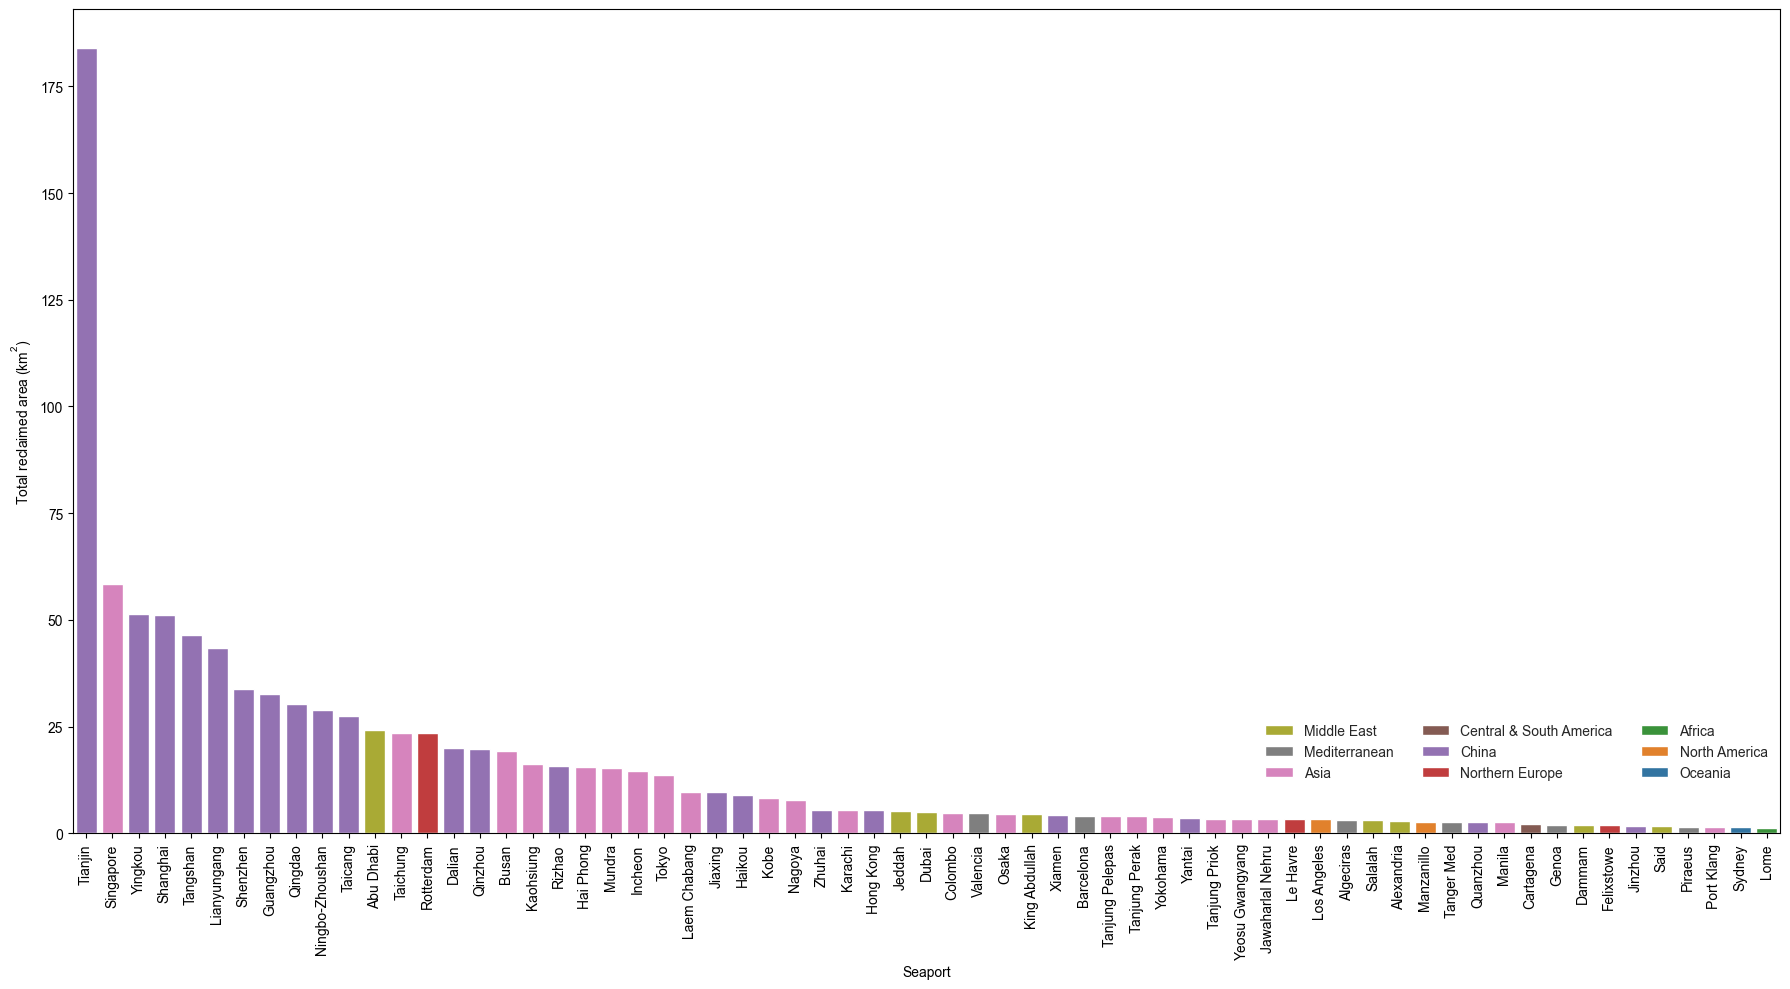

In [34]:
# Bar plot for Fig. 2 in Sengupta & Lazarus (2023)

f, ax = plt.subplots(figsize = (18, 10))

df = TEUS
df.sort_values(by=["Total reclaimed area (km^2)"], ascending=False, inplace=True)

matches = ['Middle East', 'Mediterranean', 'Asia', 'Central & South America',
          'China', 'Northern Europe', 'Africa', 'North America', 'Oceania']

custom = {'font': 'Arial',
               'xtick.direction': 'in',
               'ytick.direction': 'in',
               'xtick.top': 'True',
               'ytick.right': 'True'}

sns.set_style('ticks', rc = custom)


sns.barplot(data=df,
             x="Seaport",
             y="Total reclaimed area (km^2)",
            hue = "Region (with China)",
            palette = 'tab10_r',
            dodge = False,
            hue_order = matches
           )

plt.xticks(rotation=90)
plt.legend(loc = 'lower right', ncol = 3, frameon=False, bbox_to_anchor = (1, 0.05))

ax.set_ylabel('Total reclaimed area ($\mathregular{km^2}$)')


plt.tight_layout()

# plt.savefig('Bar-Total-Rec_V5.png', dpi = 300)

Text(10, -10, 'b')

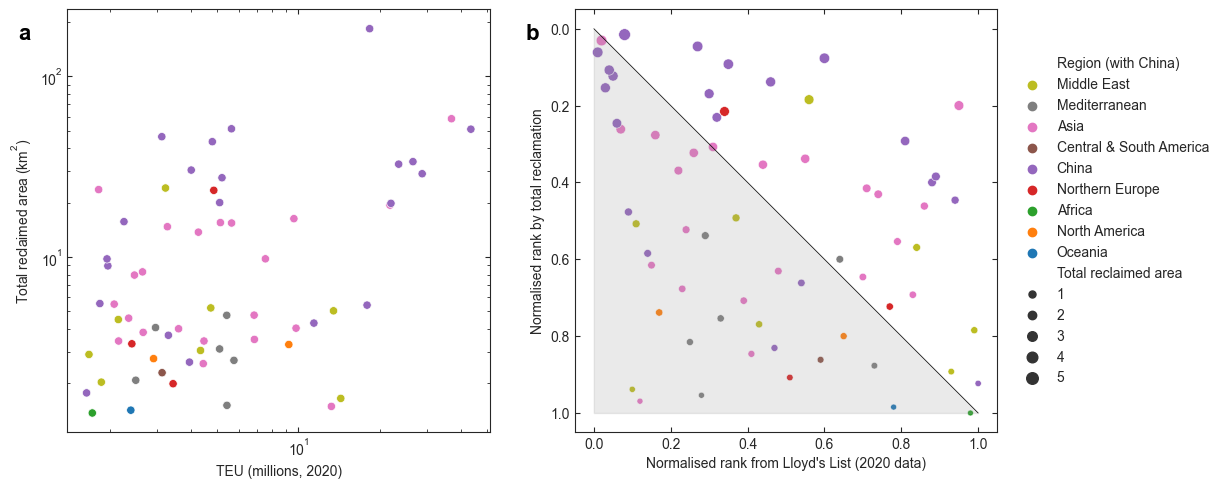

In [35]:
# For scatterplots in Fig. 4 of Sengupta & Lazarus (2023):

f, axes = plt.subplots(1, 2, figsize = (12, 6))

df = TEUS2

# PANEL A

sns.scatterplot(data = df,
                x = "TEU (millions, 2020)",
                y = "Total reclaimed area",
#                 x = "Total reclaimed area",
#                 y = "TEU (millions, 2020)",
                hue = 'Region (with China)',
                palette = 'tab10_r',
                ax = axes[0],
                legend = False
               )


sns.despine(right=False, top=False)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_box_aspect(1)

axes[0].set_ylabel("Total reclaimed area ($\mathregular{km^2}$)")
axes[0].set_xlabel("TEU (millions, 2020)")

# Panel B

sns.scatterplot(data = df,
                x = df["LL20 rank"]/np.max(df["LL20 rank"]),
                y = df['Rank by total reclamation']/np.max(df['Rank by total reclamation']),
                size = np.log(df['Total reclaimed area']),
                hue = 'Region (with China)',
                palette = 'tab10_r',
                ax = axes[1]
               )


sns.despine(right=False, top=False)
axes[1].set_box_aspect(1)

axes[1].invert_yaxis()

# make reference line
plt.plot([0, 1], [0, 1], linewidth=0.5, color = 'k')
axes[1].fill_between([0, 1], [0, 1], 1, color = '0.6', alpha=0.2)

plt.ylabel("Normalised rank by total reclamation")
plt.xlabel("Normalised rank from Lloyd's List (2020 data)")

# sns.move_legend(ax, loc = 'lower right')
axes[1].legend(loc = 'center right', bbox_to_anchor = (1.53, 0.5), frameon=False)

axes[0].annotate('a', xy=(-0.15,1), xycoords="axes fraction",
                    xytext=(10,-10), textcoords="offset points",
                    ha="left", va="top",
             size = 16, color = 'black', weight = 'semibold')

axes[1].annotate('b', xy=(-0.15,1), xycoords="axes fraction",
                    xytext=(10,-10), textcoords="offset points",
                    ha="left", va="top",
             size = 16, color = 'black', weight = 'semibold')


# plt.savefig('Scatters_paired_v2.png', dpi = 300, bbox_inches='tight')

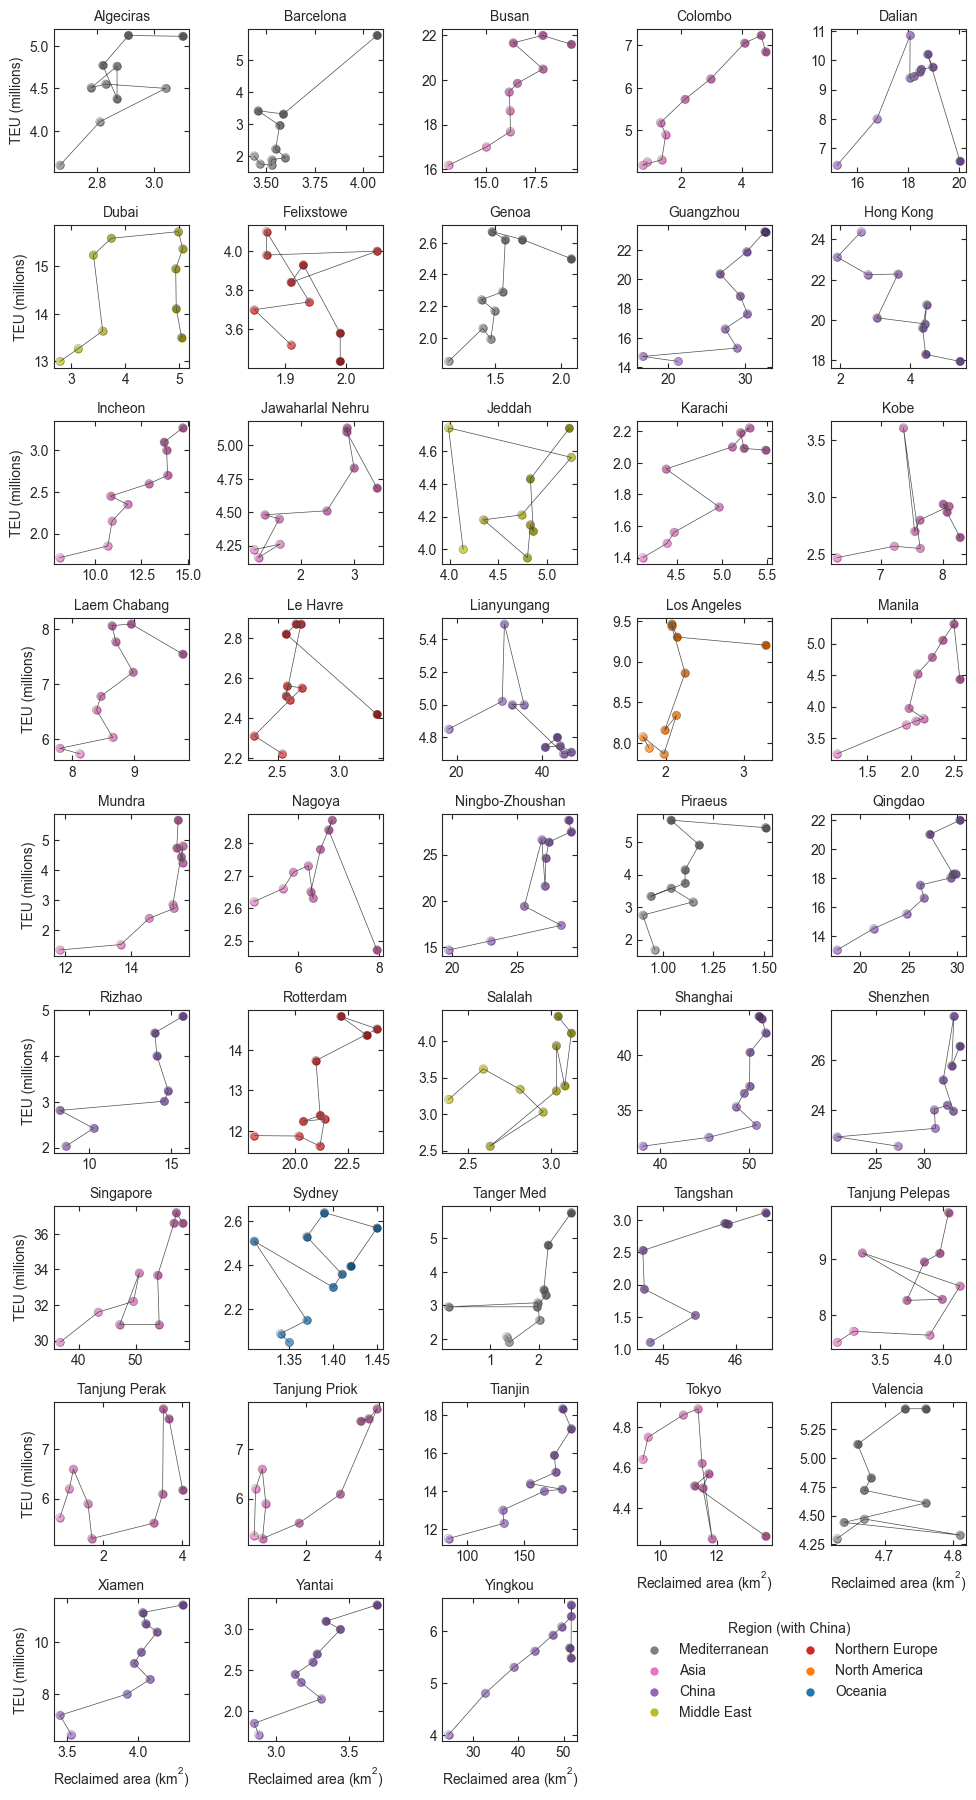

In [36]:
# Trajectories for Fig. 5 of Sengupta & Lazarus (2023):

# Facetgrid arrangement:

df = TRAJECTS

# Above, color sequence goes = ['Middle East', 'Mediterranean', 'Asia', 'Central & South America',
# 'China', 'Northern Europe', 'Africa', 'North America', 'Oceania']
#
# Here, subset goes: ['Mediterranean', 'Asia', 'China', 'Middle East', 'Northern Europe',
# 'North America', 'Oceania']...but colors need to match, so:

subset = ['#7f7f7f', '#e377c2', '#9467bd', '#bcbd22', '#d62728', '#ff7f0e', '#1f77b4']


custom = {'font': 'Arial',
               'xtick.direction': 'in',
               'ytick.direction': 'in',
               'xtick.top': 'True',
               'ytick.right': 'True'}

sns.set_style('ticks', rc = custom)

# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(df,
                     col = "Seaport",
                     hue = "Region (with China)",
#                      palette = "tab10_r",
                     palette = subset,
                     col_wrap = 5,
                     height = 2,
                     sharey = False,
                     sharex = False,
                    despine = False)


# Show the trajectory for each city
grid.map(plt.plot, "Reclaimed area (km^2, raw)", "TEU (millions)", linewidth = 0.5, color = '0.3')

grid.map(plt.scatter, "Reclaimed area (km^2, raw)", "TEU (millions)",
#                      cmap='tab10_r',
                     edgecolor ='0',
                     linewidth=0,
                     alpha = 1)

# grid.add_legend(loc='lower center', bbox_to_anchor=(0.28, -0.05), ncol=4)
grid.add_legend(loc='lower right', bbox_to_anchor=(0.73, 0.035), ncol=2)


grid.map_dataframe(sns.scatterplot,
                   "Reclaimed area (km^2, raw)",
                   "TEU (millions)",
                   hue = 'Year',
                   palette = 'gray_r',
                   edgecolor ='k',
                   linewidth=0.5,
                   alpha = 0.3
                  )

grid.set_axis_labels('Reclaimed area ($\mathregular{km^2}$)')
grid.set_titles(template = "{col_name}")


# plt.savefig('TRAJECTS_layered_v6.png', dpi = 300, bbox_inches='tight')

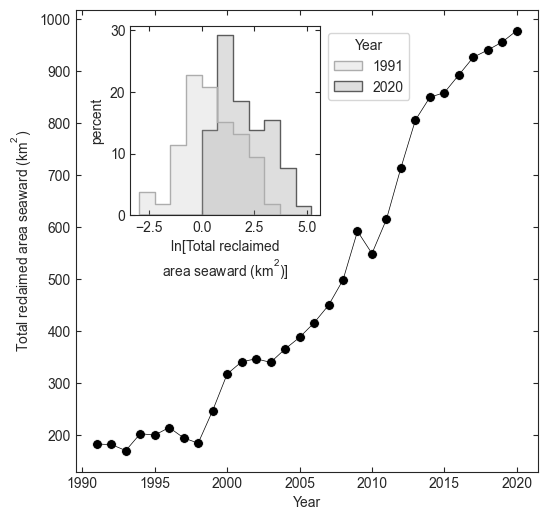

In [37]:
# Create plot for inset of Fig. 2 in Sengupta & Lazarus (2023)

f, ax = plt.subplots(figsize = (6, 6))

custom = {'font': 'Arial',
               'xtick.direction': 'in',
               'ytick.direction': 'in',
               'xtick.top': 'True',
               'ytick.right': 'True'}

sns.set_style('ticks', rc = custom)

# Main panel
sns.scatterplot(data = Ry,
             x = "Year",
             y = "Reclaimed area (km^2, raw)",
            color = 'k',
            s = 50)

sns.lineplot(data = Ry,
             x = "Year",
             y = "Reclaimed area (km^2, raw)",
            color = 'k',
            linewidth = 0.5)

plt.xlabel('Year')
plt.ylabel('Total reclaimed area seaward ($\mathregular{km^2}$)')


# Inset panel...
# axins = (ax, '30%', '30%', loc = 'upper left', borderpad = 3)
# axins = (ax, '30%', '30%', bbox_to_anchor = (0, 0.55), loc ='upper left', borderpad=1)
from matplotlib.transforms import blended_transform_factory  # noqa
transform = blended_transform_factory(f.transFigure, ax.transAxes)
axins = inset_axes(ax, '40%', '40%', bbox_to_anchor=(0.13, 0, 1, 1.025), bbox_transform=transform, loc=2, borderpad=2)

sns.histplot(data = comp,
             x  = np.log(comp['Reclaimed area (km^2, raw)']),
            hue = 'Year',
            stat = 'percent',
            element = 'step',
            fill = True,
            common_norm = False,
            palette = ['#adadad', '#5c5c5c'],
            alpha = 0.2)

plt.xlabel('ln[Total reclaimed\narea seaward ($\mathregular{km^2}$)]')
plt.ylabel('percent')
sns.move_legend(axins, loc = 'upper right', bbox_to_anchor = (1.51, 1))


# plt.legend(axins, frameon=False)

ax.set_box_aspect(1)
axins.set_box_aspect(1)

# plt.savefig('Fig2_doubleinset_v3.png', dpi = 300)

### Calculating the rolling standard deviation of the raw expansion time series...

In [38]:
# Define a function to perform the rolling operations
def custom_rolling_std(series):
    series = series.bfill()
    
    # Calculate the rolling mean within the window
    rolling_mean = series.rolling(window=3).mean()
    
    # Detrend the series within the rolling window
    detrended_series = series - rolling_mean
    
    # Calculate the standard deviation within the rolling window
    rolling_std = detrended_series.rolling(window=3).std()
    
    return rolling_std.mean()

# Group by 'Seaport' and apply the custom_rolling_std function
RollingSTDV = RECTIME.groupby('Seaport')['Reclaimed area (km^2, raw)'].apply(custom_rolling_std).reset_index()

# Rename the columns
RollingSTDV = RollingSTDV.rename(columns={'Reclaimed area (km^2, raw)': 'Mean rolling stdv (km^2)'})

print(RollingSTDV)


            Seaport  Mean rolling stdv (km^2)
0         Abu Dhabi                  1.612220
1        Alexandria                  0.125998
2         Algeciras                  0.150347
3         Barcelona                  0.084657
4             Busan                  0.452220
..              ...                       ...
60           Yantai                  0.121524
61  Yeosu Gwangyang                  0.176557
62          Yingkou                  0.828938
63         Yokohama                  0.184490
64           Zhuhai                  0.224907

[65 rows x 2 columns]


Text(0.5, 0, 'Mean rolling stdv ($\\mathregular{km^2}$)')

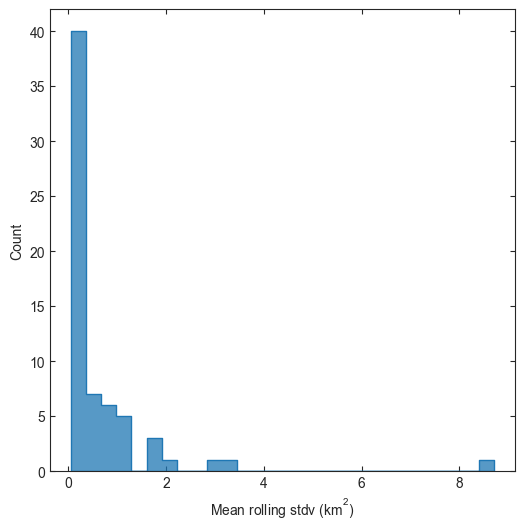

In [39]:
f, ax = plt.subplots(figsize = (6, 6))

custom = {'font': 'Arial',
               'xtick.direction': 'in',
               'ytick.direction': 'in',
               'xtick.top': 'True',
               'ytick.right': 'True'}

sns.set_style('ticks', rc = custom)

sns.histplot(data = RollingSTDV,
             x  = 'Mean rolling stdv (km^2)',
            element = 'step',
            fill = True)

plt.xlabel('Mean rolling stdv ($\mathregular{km^2}$)')

In [40]:
np.where(RollingSTDV['Mean rolling stdv (km^2)'] <= 1)[0].size

53

In [41]:
RollingSTDV = RollingSTDV.sort_values(by='Mean rolling stdv (km^2)', ascending=False)
RollingSTDV.head(15)

,Seaport,Mean rolling stdv (km^2)
56,Tianjin,8.703074
27,Lianyungang,3.359542
47,Singapore,3.009697
45,Shanghai,2.136385
52,Tangshan,1.758351
12,Guangzhou,1.746472
0,Abu Dhabi,1.612220
38,Qingdao,1.222559
50,Taichung,1.209567
46,Shenzhen,1.110316


In [42]:
part1 = TEUS[['Seaport', 'Total reclaimed area (km^2)']].copy()
part1  = part1.sort_values(by='Seaport')
part1 = part1.reset_index(drop=True)

part2 = RollingSTDV
part2 = part2.sort_values(by='Seaport')
part2 = part2.reset_index(drop=True)
part2 = part2.drop(part2.columns[0], axis=1)

stdcheck = pd.concat([part1, part2], axis = 1)

stdcheck.head(3)

,Seaport,Total reclaimed area (km^2),Mean rolling stdv (km^2)
0,Abu Dhabi,24.12,1.612220
1,Alexandria,2.89,0.125998
2,Algeciras,3.10,0.150347


In [43]:
# Total stdv across all seaports (km^2)
stdcheck['Mean rolling stdv (km^2)'].sum()

42.41684146091433

In [44]:
# Total stdv as percentage of total reclaimed area in 2020
100*(stdcheck['Mean rolling stdv (km^2)'].sum())/Rtot

4.337100353876721

In [45]:
# Cast mean rolling stdv for each seaport in terms of percentage of total reclamation for that seaport
stdcheck['perc_tot'] = 100*stdcheck['Mean rolling stdv (km^2)']/stdcheck['Total reclaimed area (km^2)']

stdcheck.head(3)

,Seaport,Total reclaimed area (km^2),Mean rolling stdv (km^2),perc_tot
0,Abu Dhabi,24.12,1.612220,6.684163
1,Alexandria,2.89,0.125998,4.359797
2,Algeciras,3.10,0.150347,4.849913


In [46]:
# Show seaports in descending order by stdv as percent of total reclamationa area:
stdcheck.sort_values(by=["perc_tot"], ascending = False, inplace=True)
stdcheck.reset_index(drop=True)
stdcheck.head(30)

,Seaport,Total reclaimed area (km^2),Mean rolling stdv (km^2),perc_tot
19,Jiaxing,9.77,0.901299,9.225174
37,Port Klang,1.49,0.130416,8.752758
18,Jeddah,5.23,0.427647,8.176812
27,Lianyungang,43.55,3.359542,7.714219
51,Tanger Med,2.68,0.199676,7.450595
30,Manila,2.57,0.171801,6.684869
0,Abu Dhabi,24.12,1.612220,6.684163
28,Lome,1.37,0.090106,6.577113
10,Felixstowe,1.99,0.117386,5.898779
31,Manzanillo,2.74,0.158999,5.802873


In [47]:
np.where(stdcheck['perc_tot'] <= 5)[0].size

47

Text(0.5, 0, 'Mean rolling stdv as percent total reclaimed area')

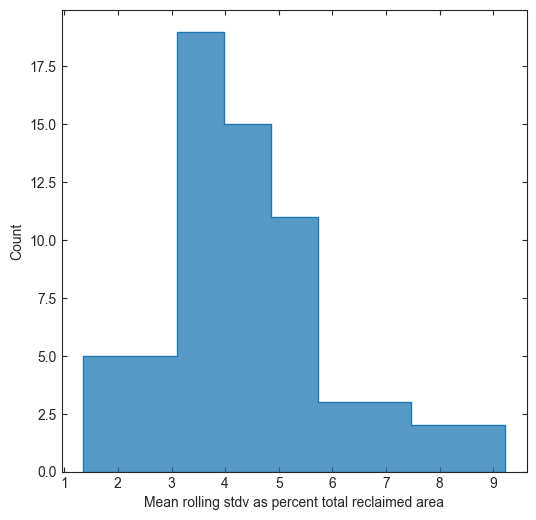

In [48]:
# Distribution of stdv as percentage of total reclamation for 65 seaports 
f, ax = plt.subplots(figsize = (6, 6))

custom = {'font': 'Arial',
               'xtick.direction': 'in',
               'ytick.direction': 'in',
               'xtick.top': 'True',
               'ytick.right': 'True'}

sns.set_style('ticks', rc = custom)

sns.histplot(data = stdcheck,
             x  = 'perc_tot',
            element = 'step',
            fill = True)

plt.xlabel('Mean rolling stdv as percent total reclaimed area')

In [49]:
RECTIME2 = RECTIME.copy()
# Define a function to perform the rolling operations
def custom_rolling_std(series):
    series = series.bfill()
    
    # Calculate the rolling mean within the window
    rolling_mean = series.rolling(window=3).mean()
    
    # Detrend the series within the rolling window
    detrended_series = series - rolling_mean
    
    # Calculate the standard deviation within the rolling window
    rolling_std = detrended_series.rolling(window=3).std()
    
    return rolling_std.mean()

# Group by 'Seaport' and apply the custom_rolling_std function
# Calculate the rolling standard deviation for each 'Seaport' group
RECTIME2['Mean rolling stdv (km^2)'] = RECTIME2.groupby('Seaport')['Reclaimed area (km^2, raw)'].transform(custom_rolling_std)

RECTIME2.head(5)


,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)",Mean rolling stdv (km^2)
0,1990,Abu Dhabi,UAE,Middle East,Middle East,NaN,1.612220
1,1990,Alexandria,Egypt,Middle East,Middle East,NaN,0.125998
2,1990,Algeciras,Spain,Mediterranean,Mediterranean,NaN,0.150347
3,1990,Barcelona,Spain,Mediterranean,Mediterranean,NaN,0.084657
4,1990,Busan,South Korea,Asia,Asia,NaN,0.452220


In [50]:

# Cast mean rolling stdv for each seaport in terms of percentage of total reclamation for that seaport
RECTIME2['perc_tot'] = 100*RECTIME2['Mean rolling stdv (km^2)']/RECTIME2.loc[RECTIME2['Year'] == 2020, 'Reclaimed area (km^2, raw)']

RECTIME2['perc_tot'] = RECTIME2.groupby('Seaport')['perc_tot'].bfill()
RECTIME2.head(10)


,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)",Mean rolling stdv (km^2),perc_tot
0,1990,Abu Dhabi,UAE,Middle East,Middle East,NaN,1.612220,6.684163
1,1990,Alexandria,Egypt,Middle East,Middle East,NaN,0.125998,4.359797
2,1990,Algeciras,Spain,Mediterranean,Mediterranean,NaN,0.150347,4.849913
3,1990,Barcelona,Spain,Mediterranean,Mediterranean,NaN,0.084657,2.080020
4,1990,Busan,South Korea,Asia,Asia,NaN,0.452220,2.332233
5,1990,Cartagena,Colombia,Central & South America,Central & South America,NaN,0.107379,4.689061
6,1990,Colombo,Sri Lanka,Asia,Asia,NaN,0.102392,2.146590
7,1990,Dalian,China,Asia,China,NaN,0.269185,1.343911
22,1990,Dammam,Saudi Arabia,Middle East,Middle East,NaN,0.115138,5.671845
8,1990,Dubai,UAE,Middle East,Middle East,NaN,0.246062,4.882185


In [51]:
# NaNs for 1990...
RECTIME2.loc[RECTIME2['Year'] == 1990, 'Mean rolling stdv (km^2)'] = pd.NA
RECTIME2.loc[RECTIME2['Year'] == 1990, 'perc_tot'] = pd.NA

RECTIME2.head(5)

,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)",Mean rolling stdv (km^2),perc_tot
0,1990,Abu Dhabi,UAE,Middle East,Middle East,NaN,NaN,NaN
1,1990,Alexandria,Egypt,Middle East,Middle East,NaN,NaN,NaN
2,1990,Algeciras,Spain,Mediterranean,Mediterranean,NaN,NaN,NaN
3,1990,Barcelona,Spain,Mediterranean,Mediterranean,NaN,NaN,NaN
4,1990,Busan,South Korea,Asia,Asia,NaN,NaN,NaN


In [52]:
RECTIME2['A_max'] = RECTIME2['Reclaimed area (km^2, raw)']+RECTIME2['Mean rolling stdv (km^2)']
RECTIME2['A_min'] = RECTIME2['Reclaimed area (km^2, raw)']-RECTIME2['Mean rolling stdv (km^2)']

RECTIME2.head(5)

,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)",Mean rolling stdv (km^2),perc_tot,A_max,A_min
0,1990,Abu Dhabi,UAE,Middle East,Middle East,NaN,NaN,NaN,NaN,NaN
1,1990,Alexandria,Egypt,Middle East,Middle East,NaN,NaN,NaN,NaN,NaN
2,1990,Algeciras,Spain,Mediterranean,Mediterranean,NaN,NaN,NaN,NaN,NaN
3,1990,Barcelona,Spain,Mediterranean,Mediterranean,NaN,NaN,NaN,NaN,NaN
4,1990,Busan,South Korea,Asia,Asia,NaN,NaN,NaN,NaN,NaN


In [53]:
RECTIME2.tail(10)

,Year,Seaport,Country,Region,Region (with China),"Reclaimed area (km^2, raw)",Mean rolling stdv (km^2),perc_tot,A_max,A_min
2006,2020,Tanjung Priok,Indonesia,Asia,Asia,3.50,0.133015,3.800443,3.633015,3.366985
2002,2020,Tianjin,China,Asia,China,183.90,8.703074,4.732503,192.603074,175.196926
2005,2020,Tokyo,Japan,Asia,Asia,13.74,0.479557,3.490223,14.219557,13.260443
2009,2020,Valencia,Spain,Mediterranean,Mediterranean,4.76,0.093093,1.955729,4.853093,4.666907
2010,2020,Xiamen,China,Asia,China,4.31,0.121354,2.815639,4.431354,4.188646
2012,2020,Yantai,China,Asia,China,3.69,0.121524,3.293329,3.811524,3.568476
1962,2020,Yeosu Gwangyang,South Korea,Asia,Asia,3.43,0.176557,5.147448,3.606557,3.253443
2011,2020,Yingkou,China,Asia,China,51.33,0.828938,1.614919,52.158938,50.501062
2013,2020,Yokohama,Japan,Asia,Asia,3.83,0.184490,4.816981,4.014490,3.645510
2014,2020,Zhuhai,China,Asia,China,5.53,0.224907,4.067027,5.754907,5.305093


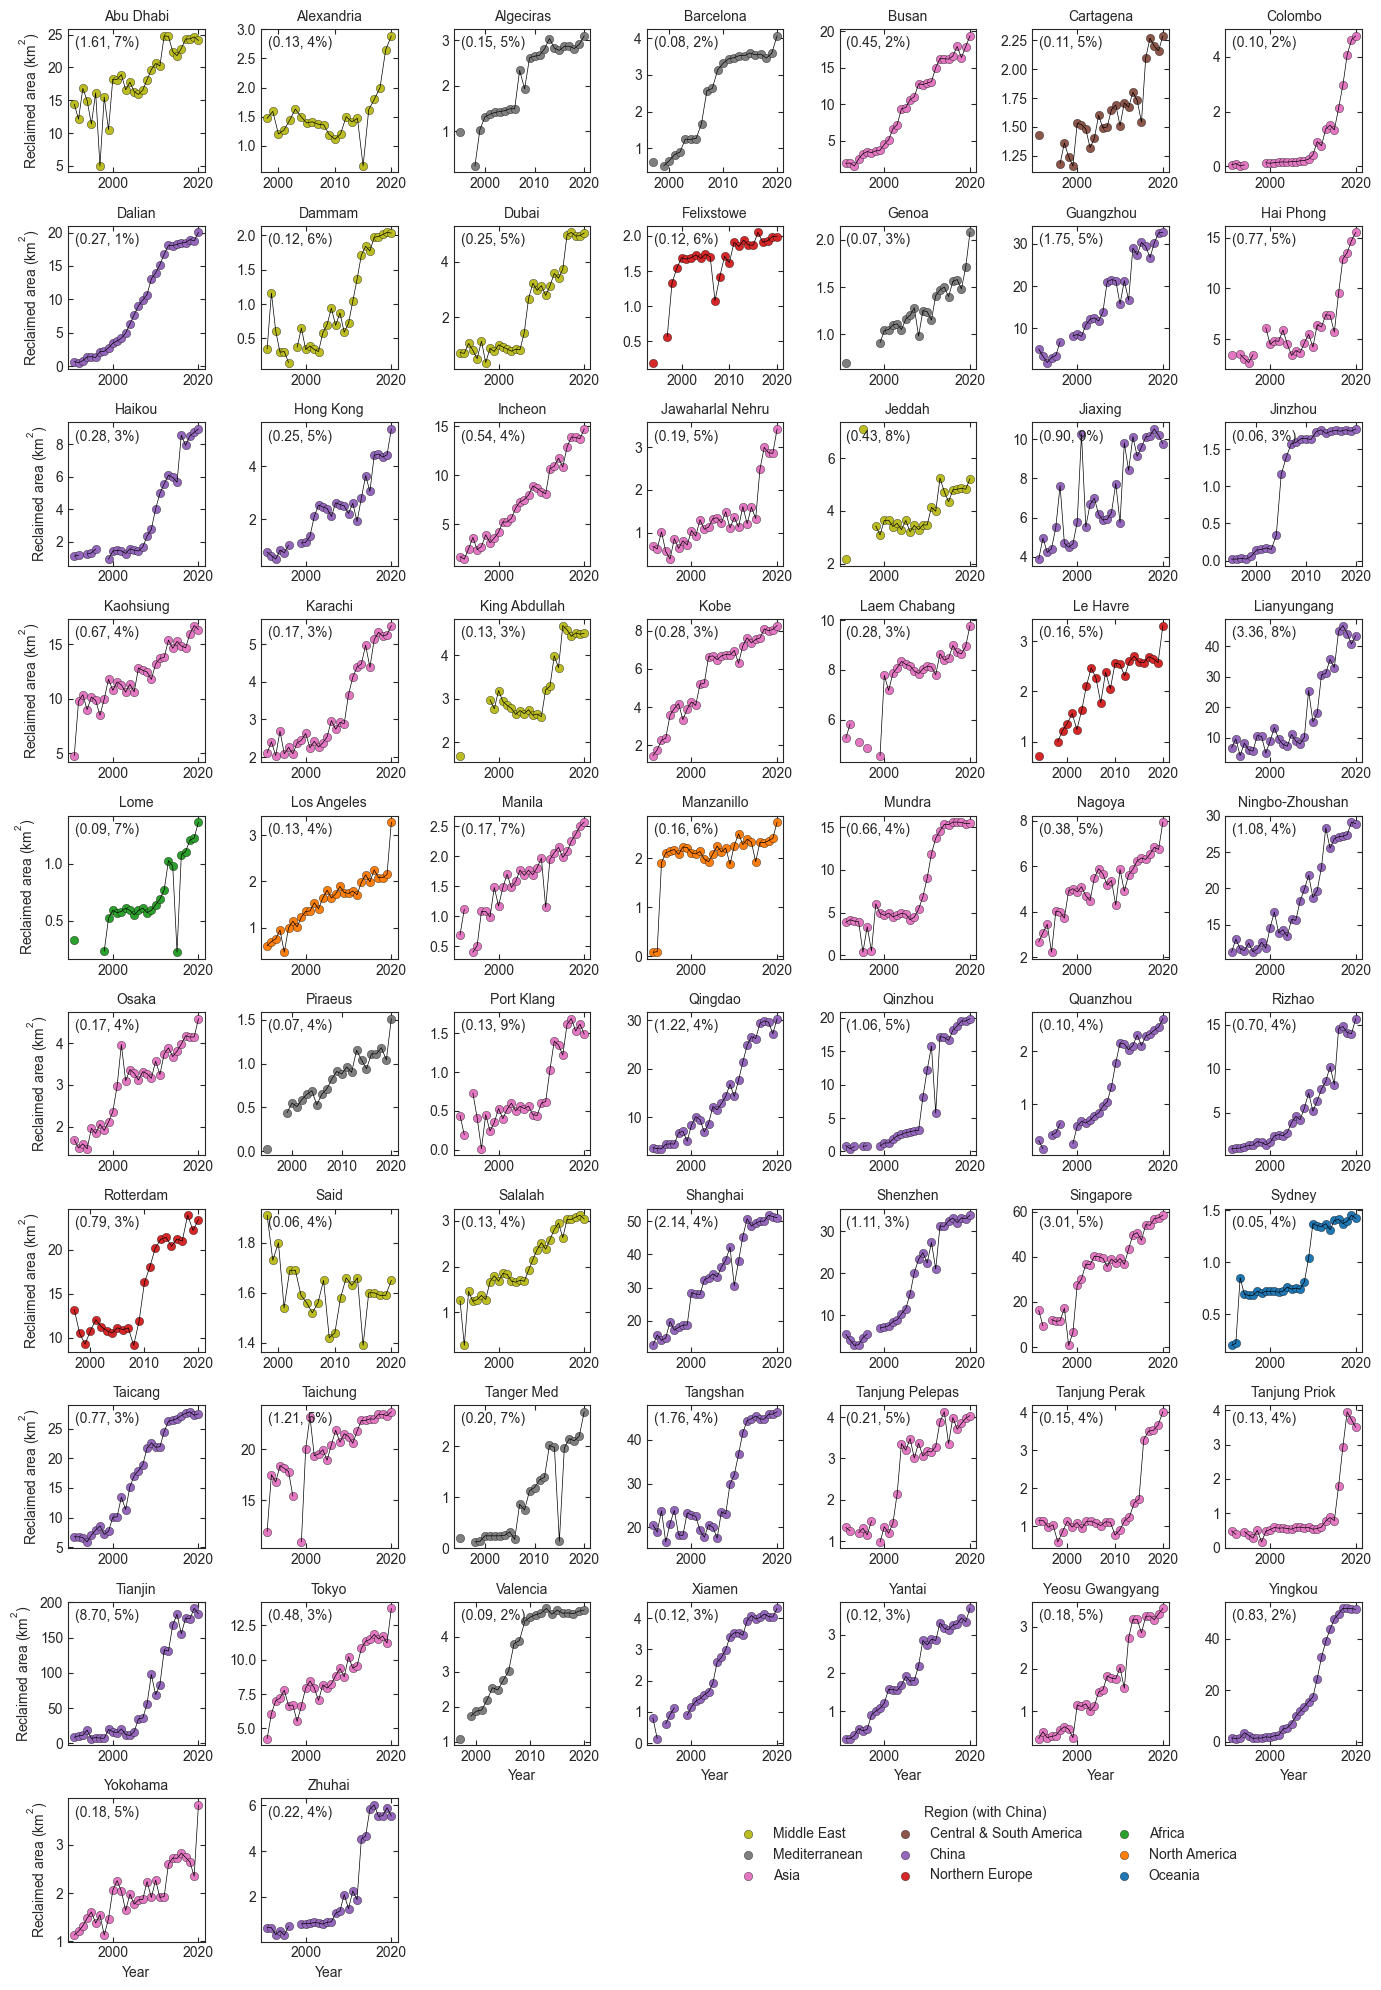

In [54]:
# Incorporate variability stats into Fig. 3 time series, Sengupta & Lazarus (2023):

# Define a custom function to annotate the plots
def annotate_plot(data1, data2, **kwargs):
    ax = plt.gca()  # Get the current Axes
    value1 = data1.iloc[-1]  # Get the 'Value' for the current Seaport
    value2 = data2.iloc[-1]  # Get the 'Value' for the current Seaport
    ax.text(0.05, 0.95, f'({value1:.2f}, {value2:.0f}%)',
            transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='left')
#     ax.text(0.1, 0.9, f'\u03C3: {value:.2f}',
#             transform=ax.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='left')

# Your existing code to create the FacetGrid
df = RECTIME2
custom = {
    'font': 'Arial',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': 'True',
    'ytick.right': 'True'
}
sns.set_style('ticks', rc=custom)

grid = sns.FacetGrid(df,
                     col="Seaport",
                     hue="Region (with China)",
                     palette="tab10_r",
                     col_wrap=7,
                     height=2,
                     sharey=False,
                     sharex=False,
                     despine=False,
                     aspect=1)

grid.map(plt.scatter, "Year", "Reclaimed area (km^2, raw)", edgecolor='k', linewidth=0.25)
grid.add_legend(loc='lower right', bbox_to_anchor=(0.65, 0.05), ncol=3)
grid.map(plt.plot, "Year", "Reclaimed area (km^2, raw)", color='k', linewidth=0.5)

# Use grid.map to apply the custom annotation function to each plot
grid.map(annotate_plot, 'Mean rolling stdv (km^2)', 'perc_tot')

grid.set_axis_labels('Year', 'Reclaimed area ($\mathregular{km^2}$)')
grid.set_titles(template="{col_name}")



# Adjust the layout to make room for the annotations
# plt.subplots_adjust(top=0.9)

# Show the plot
# plt.show()

# plt.savefig('Full_TS_v8.svg', dpi = 300, bbox_inches='tight')